# test removing an event from the tidal residual and adding it back to to the utide signal

In [2]:
#import xarray as xr

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes



/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load the real data and residulas estimated with utide

In [3]:
mb = pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/utide.residuals.montereybay.1996.2021.csv")
pr = pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/utide.residuals.pointreyes.1996.2021.csv")

dtformat = '%Y-%m-%dT%H:%M:%S'
mb['Date Time'] = pd.to_datetime(mb['Date Time'],format=dtformat)#.asfreq('15min')
mb.set_index("Date Time",inplace=True)
mb.index.names = ['datetime']
mb = mb.asfreq('6min')
pr['Date Time'] = pd.to_datetime(pr['Date Time'],format=dtformat)#.asfreq('15min')
pr.set_index("Date Time",inplace=True)
pr.index.names = ['datetime']
pr=pr.asfreq('6min')
pr

,Date Time.1,Water Level,Sigma,O or I (for verified),F,R,L,Quality,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide
datetime,,,,,,,,,,,,,,,
1995-12-31 16:00:00,1995-12-31 16:00:00,0.334,0.163,0.0,0.0,0.0,0.0,v,0.0,0.334,0.334,-0.589097,-0.589097,-0.093633,-0.495464
1995-12-31 16:06:00,1995-12-31 16:06:00,0.390,0.095,0.0,0.0,0.0,0.0,v,0.0,0.390,0.390,-0.533097,-0.533097,-0.061228,-0.471869
1995-12-31 16:12:00,1995-12-31 16:12:00,0.383,0.085,0.0,0.0,0.0,0.0,v,0.0,0.383,0.383,-0.540097,-0.540097,-0.092324,-0.447773
1995-12-31 16:18:00,1995-12-31 16:18:00,0.372,0.088,0.0,0.0,0.0,0.0,v,0.0,0.372,0.372,-0.551097,-0.551097,-0.127858,-0.423239
1995-12-31 16:24:00,1995-12-31 16:24:00,0.411,0.077,0.0,0.0,0.0,0.0,v,0.0,0.411,0.411,-0.512097,-0.512097,-0.113769,-0.398328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 23:30:00,2021-10-01 23:30:00,0.479,0.033,0.0,0.0,0.0,0.0,v,0.0,0.479,0.479,-0.524586,-0.524586,-0.015510,-0.509076
2021-10-01 23:36:00,2021-10-01 23:36:00,0.467,0.052,0.0,0.0,0.0,0.0,v,0.0,0.467,0.467,-0.536586,-0.536586,0.000212,-0.536798
2021-10-01 23:42:00,2021-10-01 23:42:00,0.451,0.034,0.0,0.0,0.0,0.0,v,0.0,0.451,0.451,-0.552586,-0.552586,0.011110,-0.563696


## These time series are very large! Trim to a year for the testing

In [4]:
mb_2020=mb.loc['2020']
pr_2020=pr.loc['2020']
pr_2020

,Date Time.1,Water Level,Sigma,O or I (for verified),F,R,L,Quality,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide
datetime,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,0.733,0.047,0.0,0.0,0.0,0.0,v,0.0,0.733,0.733,-0.265102,-0.265102,-0.087643,-0.177459
2020-01-01 00:06:00,2020-01-01 00:06:00,0.812,0.085,0.0,0.0,0.0,0.0,v,0.0,0.812,0.812,-0.186102,-0.186102,-0.037895,-0.148208
2020-01-01 00:12:00,2020-01-01 00:12:00,0.896,0.045,0.0,0.0,0.0,0.0,v,0.0,0.896,0.896,-0.102102,-0.102102,0.016884,-0.118987
2020-01-01 00:18:00,2020-01-01 00:18:00,0.912,0.045,0.0,0.0,0.0,0.0,v,0.0,0.912,0.912,-0.086102,-0.086102,0.003754,-0.089857
2020-01-01 00:24:00,2020-01-01 00:24:00,0.915,0.040,0.0,0.0,0.0,0.0,v,0.0,0.915,0.915,-0.083102,-0.083102,-0.022225,-0.060877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:30:00,2020-12-31 23:30:00,1.138,0.081,0.0,0.0,0.0,0.0,v,0.0,1.138,1.138,0.136762,0.136762,-0.113050,0.249812
2020-12-31 23:36:00,2020-12-31 23:36:00,1.191,0.097,0.0,0.0,0.0,0.0,v,0.0,1.191,1.191,0.189762,0.189762,-0.080308,0.270070
2020-12-31 23:42:00,2020-12-31 23:42:00,1.214,0.084,0.0,0.0,0.0,0.0,v,0.0,1.214,1.214,0.212762,0.212762,-0.076283,0.289045


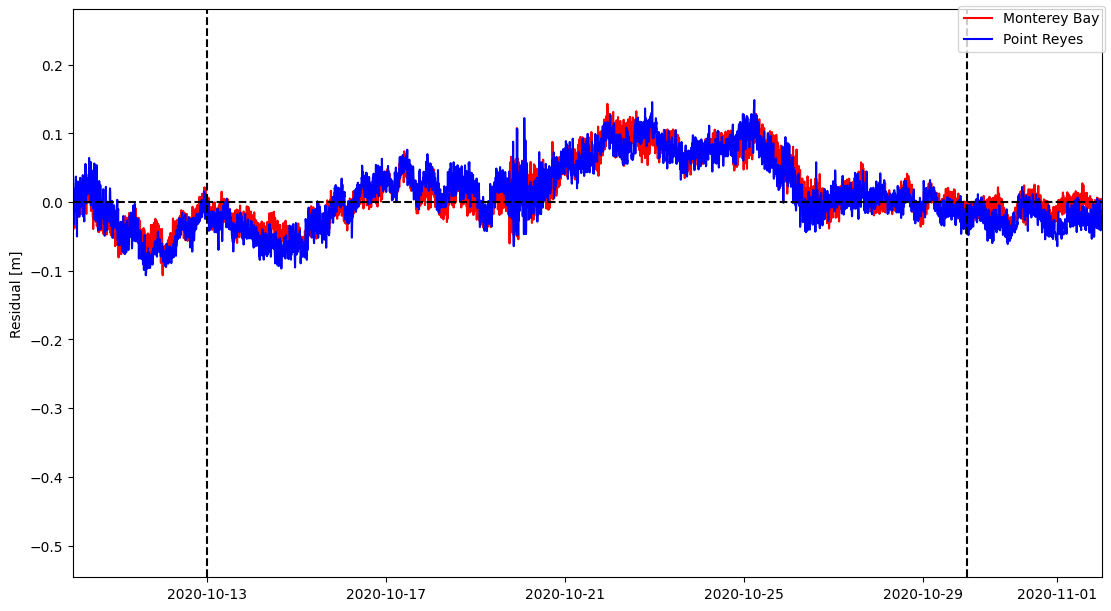

In [5]:
#plot the residual for an event
fig, ax = plt.subplots(layout="constrained",figsize=(11,6))

ax.plot(mb_2020['Residual'], label='Monterey Bay',color='r')
ax.plot(pr_2020['Residual'], label='Point Reyes',color='b')
ax.set_ylabel("Residual [m]")
#start 2
ax.axvline(x = datetime(2020,10,13), color = 'k',linestyle='--')
#end 2
ax.axvline(x = datetime(2020,10,30), color = 'k',linestyle='--')
ax.axhline(y=0, color = 'k',linestyle='--')
#ax.axhline(y=0, xmin = datetime(2020,1,1), xmax = datetime(2020,12,31), color = 'k',linestyle='--')

ax.set_xlim(datetime(2020,10,10),datetime(2020,11,2))
fig.legend()
plt.show()

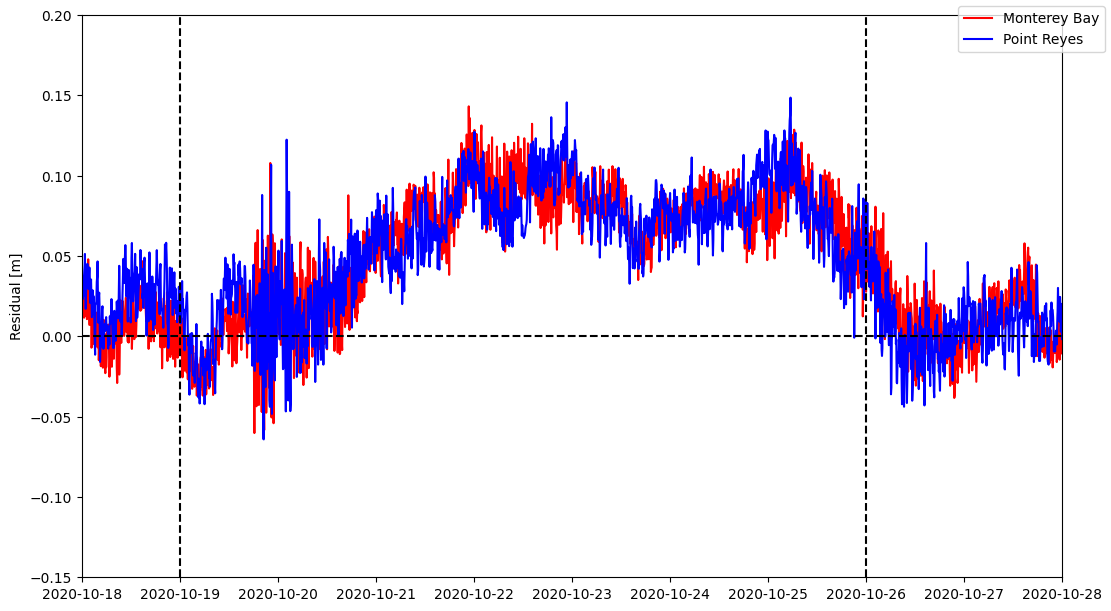

In [6]:
#zoom in on the event
#plot the residual for an event
fig, ax = plt.subplots(layout="constrained",figsize=(11,6))

ax.plot(mb_2020['Residual'], label='Monterey Bay',color='r')
ax.plot(pr_2020['Residual'], label='Point Reyes',color='b')
ax.set_ylabel("Residual [m]")
#start 2
ax.axvline(x = datetime(2020,10,19), color = 'k',linestyle='--')
#end 2
ax.axvline(x = datetime(2020,10,26), color = 'k',linestyle='--')
ax.axhline(y=0, color = 'k',linestyle='--')
#ax.axhline(y=0, xmin = datetime(2020,1,1), xmax = datetime(2020,12,31), color = 'k',linestyle='--')

ax.set_xlim(datetime(2020,10,18),datetime(2020,10,28))
ax.set_ylim(-0.15,0.2)
fig.legend()
plt.show()

# not sufficient to choose the peak ends by eye, plot the filtered on top and use the places that crosses 0

In [34]:
#what is the frequency of this noise?
mb_ft = np.fft.fft(mb_2020.Residual)
pr_ft = np.fft.fft(pr_2020.Residual)
T = 6*60;             # Sampling period 
T_days = 6/(60*24)
Fs = 1/T;            # Sampling frequency 
Fs_days= 1/T_days
L = len(mb_2020.Residual)             # Length of signal
#t = (0:L-1)*T;        # Time vector
f_x = Fs/L*np.arange(0,L)     #frequency vector for x axis
f_x_days = Fs_days/L*np.arange(0,L)

In [35]:
Fs_days

240.0

In [9]:
len(mb_2020.Residual)

87840

Text(0.5, 0, 'frequency')

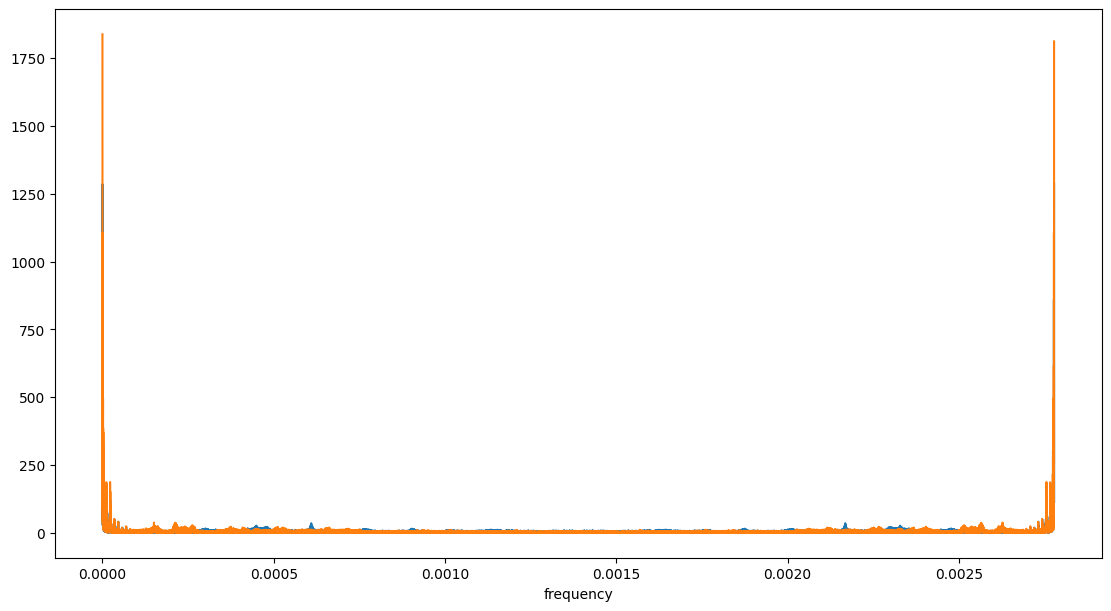

In [10]:
fig, ax = plt.subplots(layout="constrained",figsize=(11,6))
ax.plot(f_x, np.abs(mb_ft), label='fft monterey bay')
ax.plot(f_x, np.abs(pr_ft), label='fft point reyes')
ax.set_xlabel('frequency')


(0.0, 119.99863387978142)

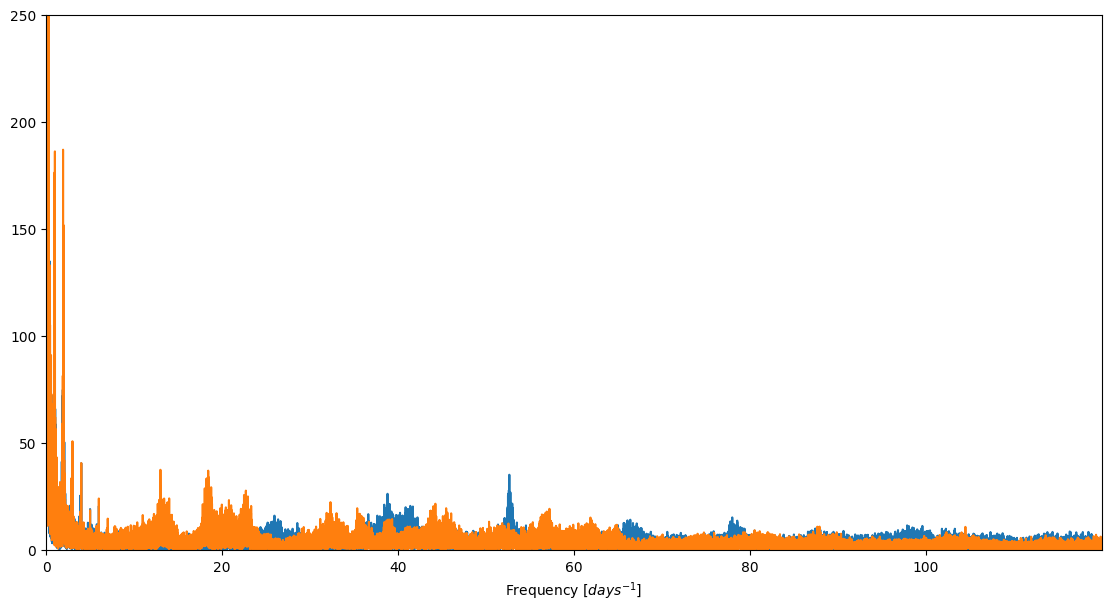

In [38]:
#plot just half and frequency in days and cap y axis at 250

fig, ax = plt.subplots(layout="constrained",figsize=(11,6))
ax.plot(f_x_days, np.abs(mb_ft), label='fft monterey bay')
ax.plot(f_x_days, np.abs(pr_ft), label='fft point reyes')
ax.set_xlabel('Frequency [$days^{-1}$]')
ax.set_ylim(0,250)
ax.set_xlim(0,f_x_days[-1]/2)


(0.0, 15.0)

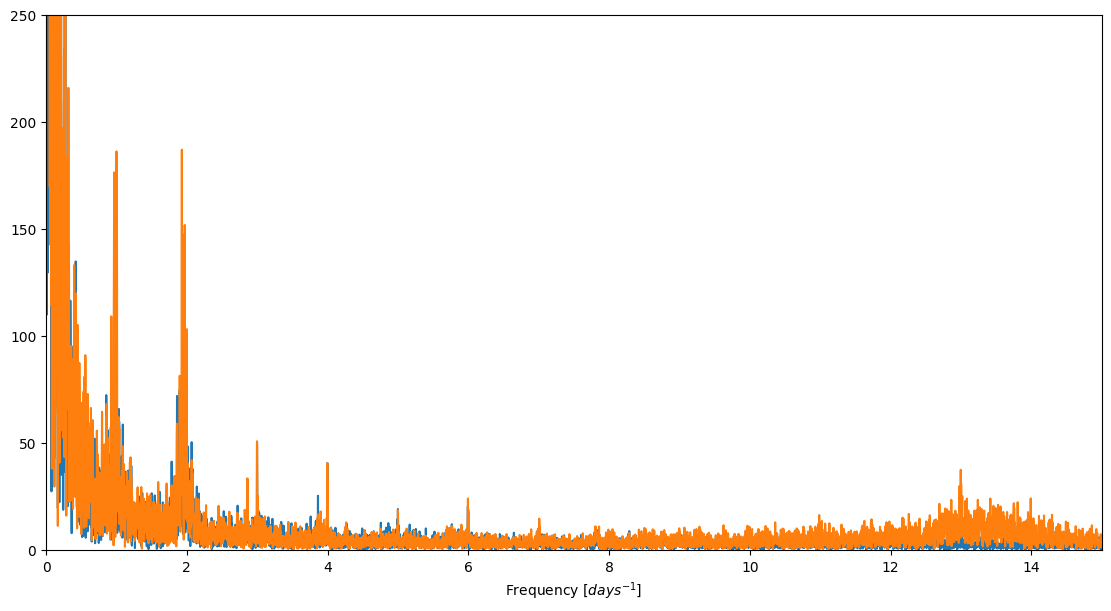

In [39]:
fig, ax = plt.subplots(layout="constrained",figsize=(11,6))
ax.plot(f_x_days, np.abs(mb_ft), label='fft monterey bay')
ax.plot(f_x_days, np.abs(pr_ft), label='fft point reyes')
ax.set_xlabel('Frequency [$days^{-1}$]')
ax.set_ylim(0,250)
ax.set_xlim(0,15)

In [12]:
# no high frequency peak, probably a bit broadband, try moving average
win=25*(60/6) # 25 hour window, how many samples if 6 minute frequency of collection
mb_2020_roll=mb_2020.rolling('4h').mean()

In [13]:
mb_2020_roll

,Water Level,Sigma,O or I (for verified),F,R,L,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide
datetime,,,,,,,,,,,,,
2020-01-01 00:00:00,0.830000,0.081000,0.0,0.0,0.0,0.0,0.0,0.830000,0.830000,-0.126120,-0.126120,0.020549,-0.146669
2020-01-01 00:06:00,0.850000,0.083000,0.0,0.0,0.0,0.0,0.0,0.850000,0.850000,-0.106120,-0.106120,0.027460,-0.133580
2020-01-01 00:12:00,0.877333,0.085000,0.0,0.0,0.0,0.0,0.0,0.877333,0.877333,-0.078787,-0.078787,0.041753,-0.120539
2020-01-01 00:18:00,0.892000,0.084000,0.0,0.0,0.0,0.0,0.0,0.892000,0.892000,-0.064120,-0.064120,0.043438,-0.107558
2020-01-01 00:24:00,0.916800,0.083200,0.0,0.0,0.0,0.0,0.0,0.916800,0.916800,-0.039320,-0.039320,0.055331,-0.094651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:30:00,0.585225,0.099550,0.0,0.0,0.0,0.0,0.0,0.585225,0.585225,-0.374082,-0.374082,-0.056191,-0.317890
2020-12-31 23:36:00,0.612775,0.100375,0.0,0.0,0.0,0.0,0.0,0.612775,0.612775,-0.346532,-0.346532,-0.056153,-0.290379
2020-12-31 23:42:00,0.641650,0.100500,0.0,0.0,0.0,0.0,0.0,0.641650,0.641650,-0.317657,-0.317657,-0.054491,-0.263165


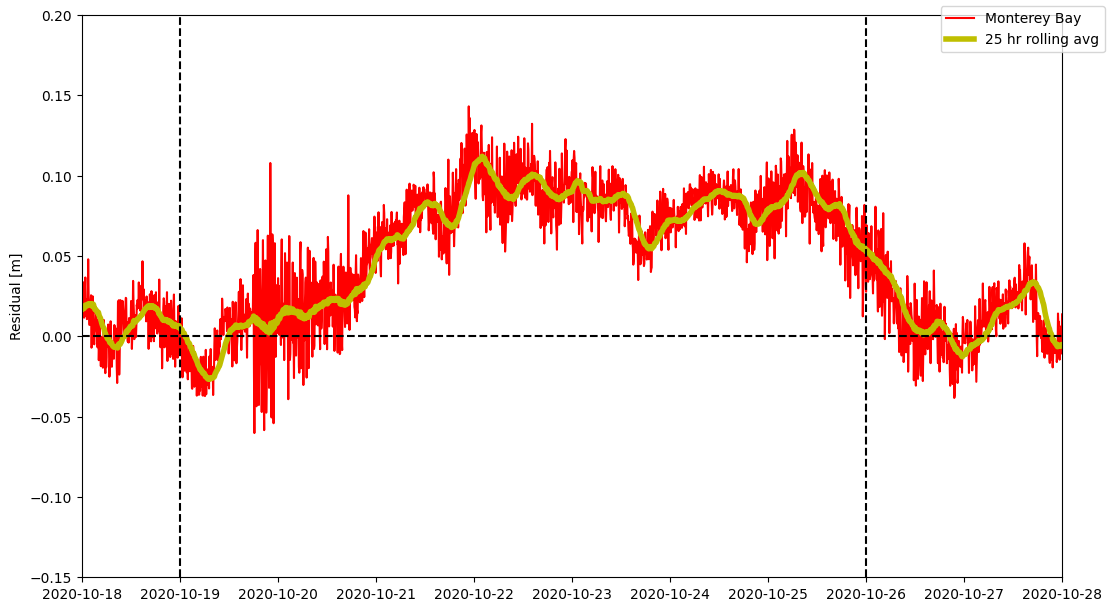

In [14]:
#zoom in on the event
#plot the residual for an event
fig, ax = plt.subplots(layout="constrained",figsize=(11,6))

ax.plot(mb_2020['Residual'], label='Monterey Bay',color='r')
#ax.plot(pr_2020['Residual'], label='Point Reyes',color='b')
ax.plot(mb_2020_roll['Residual'],label='25 hr rolling avg',color='y',linewidth=4)
ax.set_ylabel("Residual [m]")
#start 2
ax.axvline(x = datetime(2020,10,19), color = 'k',linestyle='--')
#end 2
ax.axvline(x = datetime(2020,10,26), color = 'k',linestyle='--')
ax.axhline(y=0, color = 'k',linestyle='--')
#ax.axhline(y=0, xmin = datetime(2020,1,1), xmax = datetime(2020,12,31), color = 'k',linestyle='--')

ax.set_xlim(datetime(2020,10,18),datetime(2020,10,28))
ax.set_ylim(-0.15,0.2)
fig.legend()
plt.show()

In [15]:
#find the roots
roots=mb_2020_roll[(mb_2020_roll['Residual']<0.001) & (mb_2020_roll['Residual']>-0.001)]
roots

,Water Level,Sigma,O or I (for verified),F,R,L,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide
datetime,,,,,,,,,,,,,
2020-01-02 05:30:00,1.351500,0.112625,0.0,0.0,0.05,0.0,0.0,1.351500,1.351500,0.395370,0.395370,0.000165,0.395205
2020-01-02 05:42:00,1.364500,0.113825,0.0,0.0,0.10,0.0,0.0,1.364500,1.364500,0.408370,0.408370,-0.000245,0.408615
2020-01-02 10:12:00,1.064075,0.109975,0.0,0.0,0.00,0.0,0.0,1.064075,1.064075,0.107943,0.107943,-0.000326,0.108270
2020-01-02 10:24:00,1.042950,0.109425,0.0,0.0,0.00,0.0,0.0,1.042950,1.042950,0.086818,0.086818,-0.000624,0.087443
2020-01-02 17:00:00,1.086225,0.104850,0.0,0.0,0.00,0.0,0.0,1.086225,1.086225,0.130091,0.130091,0.000079,0.130012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 07:54:00,1.570375,0.094025,0.0,0.0,0.00,0.0,0.0,1.570375,1.570375,0.611109,0.611109,0.000359,0.610750
2020-12-29 03:00:00,1.089375,0.092750,0.0,0.0,0.00,0.0,0.0,1.089375,1.089375,0.130093,0.130093,0.000971,0.129122
2020-12-29 03:06:00,1.082925,0.093350,0.0,0.0,0.00,0.0,0.0,1.082925,1.082925,0.123643,0.123643,0.000067,0.123576


In [16]:
#roots in a range
start_date=datetime(2020,10,18)
end_date=datetime(2020,10,28)
# df.loc['2000-6-1':'2000-6-10']
# mask = (roots > start_date) & (roots <= end_date)
roots_in_win=roots.loc[start_date:end_date]
gap_length=roots_in_win.index[1:]-roots_in_win.index[0:-1]
roots_in_win['dummy']=np.arange(0,len(roots_in_win['Residual']))
roots_in_win['gap_length']=gap_length.union(pd.TimedeltaIndex(['0 days']),sort=False)
roots_in_win
#the max gap length corresponds to the start date because the union step added 0 to the end

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


,Water Level,Sigma,O or I (for verified),F,R,L,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide,dummy,gap_length
datetime,,,,,,,,,,,,,,,
2020-10-18 06:00:00,0.691525,0.033950,0.0,0.0,0.0,0.0,0.0,0.691525,0.691525,-0.267131,-0.267131,0.000369,-0.267500,0,0 days 00:06:00
2020-10-18 06:06:00,0.685075,0.034125,0.0,0.0,0.0,0.0,0.0,0.685075,0.685075,-0.273581,-0.273581,-0.000477,-0.273103,1,0 days 00:06:00
2020-10-18 06:12:00,0.680300,0.034225,0.0,0.0,0.0,0.0,0.0,0.680300,0.680300,-0.278356,-0.278356,-0.000956,-0.277400,2,0 days 03:54:00
2020-10-18 10:06:00,1.426375,0.047850,0.0,0.0,0.0,0.0,0.0,1.426375,1.426375,0.467718,0.467718,-0.000690,0.468408,3,0 days 00:06:00
2020-10-18 10:12:00,1.456900,0.048225,0.0,0.0,0.0,0.0,0.0,1.456900,1.456900,0.498243,0.498243,-0.000361,0.498604,4,0 days 00:06:00
2020-10-18 10:18:00,1.486750,0.048575,0.0,0.0,0.0,0.0,0.0,1.486750,1.486750,0.528093,0.528093,-0.000300,0.528393,5,0 days 00:06:00
2020-10-18 10:24:00,1.516225,0.048875,0.0,0.0,0.0,0.0,0.0,1.516225,1.516225,0.557568,0.557568,-0.000128,0.557696,6,0 days 00:06:00
2020-10-18 10:30:00,1.544875,0.049150,0.0,0.0,0.0,0.0,0.0,1.544875,1.544875,0.586218,0.586218,-0.000215,0.586432,7,0 days 00:06:00
2020-10-18 10:36:00,1.573150,0.049500,0.0,0.0,0.0,0.0,0.0,1.573150,1.573150,0.614493,0.614493,-0.000032,0.614525,8,0 days 00:06:00


In [17]:
#now index the residuals between the index of the max gap_length and the one after
start_event=roots_in_win['gap_length'].idxmax()
start_dummy=roots_in_win.loc[start_event].dummy
print(start_dummy)
end_event=roots_in_win[roots_in_win.dummy==(start_dummy+1)].dummy.idxmax()
print(start_event)
print(end_event)

19
2020-10-19 12:06:00
2020-10-26 14:12:00


In [27]:
#subtract the filtered signal in this range from the range
event=mb_2020_roll.loc[start_event:end_event].Residual
event
mb_2020['Residual_no_event']=mb_2020.Residual.loc[start_event:end_event]-event

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


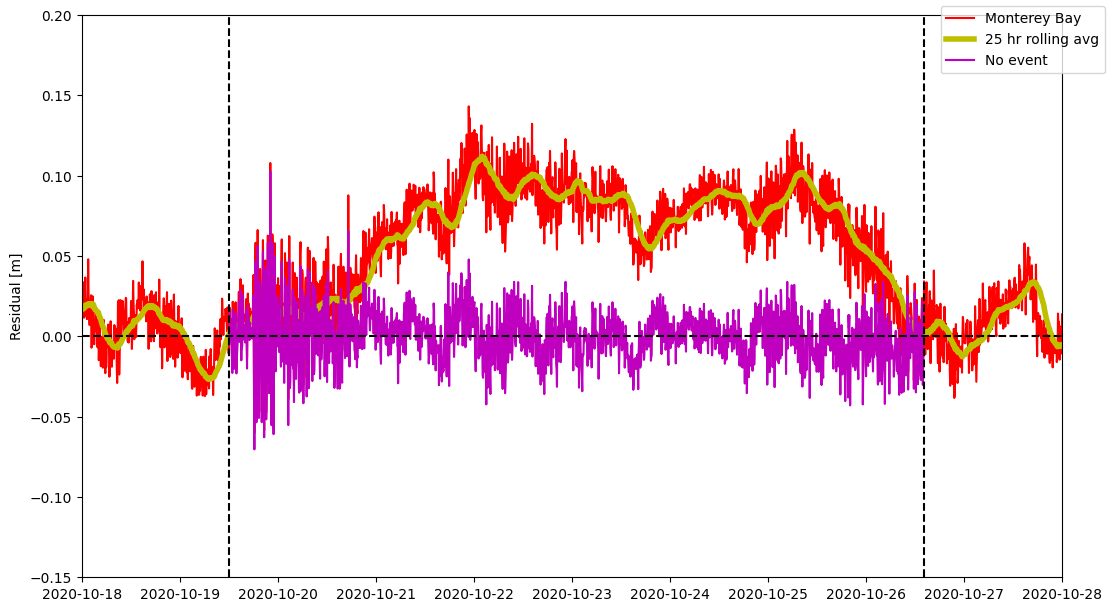

In [28]:
#plot them together
#zoom in on the event
#plot the residual for an event
fig, ax = plt.subplots(layout="constrained",figsize=(11,6))

ax.plot(mb_2020['Residual'], label='Monterey Bay',color='r')
#ax.plot(pr_2020['Residual'], label='Point Reyes',color='b')
ax.plot(mb_2020_roll['Residual'],label='25 hr rolling avg',color='y',linewidth=4)
ax.plot(mb_2020['Residual_no_event'],label='No event',color='m')
ax.set_ylabel("Residual [m]")
#start 2
ax.axvline(x = start_event, color = 'k',linestyle='--')
#end 2
ax.axvline(x = end_event, color = 'k',linestyle='--')
ax.axhline(y=0, color = 'k',linestyle='--')
#ax.axhline(y=0, xmin = datetime(2020,1,1), xmax = datetime(2020,12,31), color = 'k',linestyle='--')

ax.set_xlim(datetime(2020,10,18),datetime(2020,10,28))
ax.set_ylim(-0.15,0.2)
fig.legend()
plt.show()

In [19]:
roots_in_win[start_event:]

,Water Level,Sigma,O or I (for verified),F,R,L,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide,dummy,gap_length
datetime,,,,,,,,,,,,,,,
2020-10-19 12:06:00,1.781075,0.048075,0.0,0.0,0.0,0.0,0.0,1.781075,1.781075,0.822408,0.822408,0.000955,0.821453,19,7 days 02:06:00
2020-10-26 14:12:00,0.851450,0.045275,0.0,0.0,0.0,0.0,0.0,0.851450,0.851450,-0.107278,-0.107278,0.000846,-0.108125,20,0 days 06:24:00
2020-10-26 20:36:00,1.385475,0.051725,0.0,0.0,0.0,0.0,0.0,1.385475,1.385475,0.426744,0.426744,0.000886,0.425858,21,0 days 00:06:00
2020-10-26 20:42:00,1.387250,0.051825,0.0,0.0,0.0,0.0,0.0,1.387250,1.387250,0.428519,0.428519,-0.000906,0.429426,22,0 days 08:18:00
2020-10-27 05:00:00,0.516975,0.038350,0.0,0.0,0.0,0.0,0.0,0.516975,0.516975,-0.441759,-0.441759,-0.000939,-0.440820,23,0 days 00:06:00
2020-10-27 05:06:00,0.535300,0.038400,0.0,0.0,0.0,0.0,0.0,0.535300,0.535300,-0.423434,-0.423434,-0.000519,-0.422914,24,0 days 00:06:00
2020-10-27 05:12:00,0.554825,0.038425,0.0,0.0,0.0,0.0,0.0,0.554825,0.554825,-0.403909,-0.403909,0.000186,-0.404095,25,0 days 16:24:00
2020-10-27 21:36:00,1.371725,0.047700,0.0,0.0,0.0,0.0,0.0,1.371725,1.371725,0.412985,0.412985,0.000293,0.412692,26,0 days 00:00:00


In [20]:
# test=roots_in_win.index[1:]-roots_in_win.index[0:-1]
# test
# a=pd.TimedeltaIndex(['0 days'])
# cat=test.union(a,sort=False)
# cat

In [21]:
gap_length.idxmax()

AttributeError: 'TimedeltaIndex' object has no attribute 'idxmax'

In [ ]:
#take the mean from this period and subtract it

In [ ]:
len(pr)

In [ ]:
len(mb)

In [ ]:
f=1000
t=1/f
print(str(t+ 'period in s')
t=6*60
f=1/t
print(f + 'frequency in Hz')